# Projekt Zaliczeniowy Modelowanie w Naukach o Ziemi

Projekt jest na ocenę. Rezultatem ma być kompletne sprawozdanie. Sprawozdania w formacie pdf przesyłamy w terminie do ostatniego dnia semestru.

Dane do projektu: `plik daily_ice_edge.csv`.

### Krok 0

1. Po przemyśleniu układu danych narysować kontur przedstawiający minimalny zasięg lodu w analizowanym okresie dla wszystkich kątów. 

  a. Przemyśleć układ danych
  
  b. Narysować kontur przedstawiający minimalny zasięg lodu w analizowanym okresie dla wszystkich kątów

Warto zapoznać się z kształtem Antarktydy.   

### Krok 1
  
1. Dla wszystkich kątów (dla każdego z osobna) znaleźć model matematyczny zasięgu lodu w funkcji czasu. 

  a. Zbudować model matematyczny dla każdej kolumny w oparciu o funkcji trygonometryczne (sinusoidalna cykliczność; można o to zapytać).

Uwaga na próbkowanie w czasie oraz na fakt, że czasami lodu morskiego dla danego kąta może nie być. 

### Krok 2
  
1. Stworzyć animację przedstawiającą zmianę w czasie zarówno rzeczywistego jak i wymodelowane.

### Krok 3
 
1. Zaproponować i *w miarę możliwości* obliczyć model zasięgu lodu biorący pod uwagę wszystkie dane na raz (`f(Lat, Lon, t)`).

  a. Przekonać, że świta nam w głowie jakaś idea.

## Wskazówki 

Można zbudować model bazując na sinusach i cosinusach dla każdego kierunku z osobna. Po powtórzeniu dla wszystkich azymutów pojawi się macierz, którą animujemy.

Po narysowaniu minimalnego zasięgu lodu w układzie biegunowym otrzymamy minimalny zasięg lodu przypominający kształt Antarktydy. Uzyskujemy to poprzez znalezienie minimalnej wartości w każdej kolumnie i narysowanie tego w układzie biegunowym.


In [6]:
# install.packages("ggplot2") # nolint: commented_code_linter.
library(ggplot2)

## Dane do projektu

Plik `daily_ice_edge.csv` zawiera informację o zasięgu lodu morskiego wokół Antarktydy dla wszystkich długości geograficznych - w formacie długość-szerokość - na przestrzeni wielu lat. Dane są zapisane w formie macierzy, gdzie wiersze odpowiadają szerokości geograficznej, a kolumny długości geograficznej.

In [7]:
daily_ice_edge <- read.csv(
  "./data/daily_ice_edge.csv"
)

daily_open_water <- read.csv(
  "./data/daily_open_water.csv"
)


In [8]:
# View(daily_ice_edge) # nolint: commented_code_linter.
# View(daily_open_water) # nolint: commented_code_linter.

## Minimalny zasięg lodu na Antarktydzie

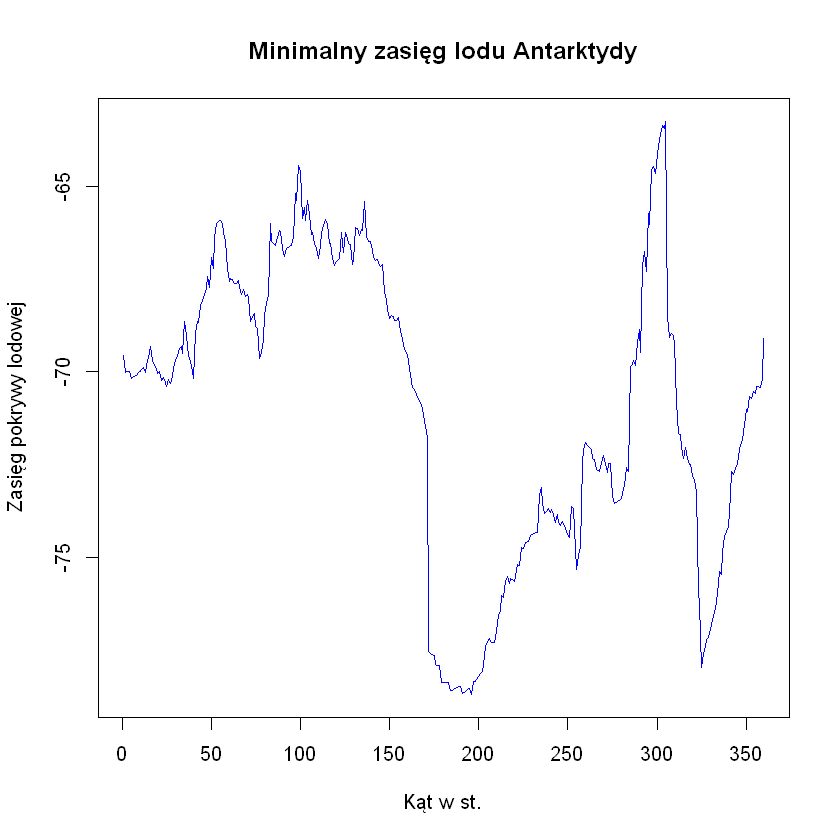

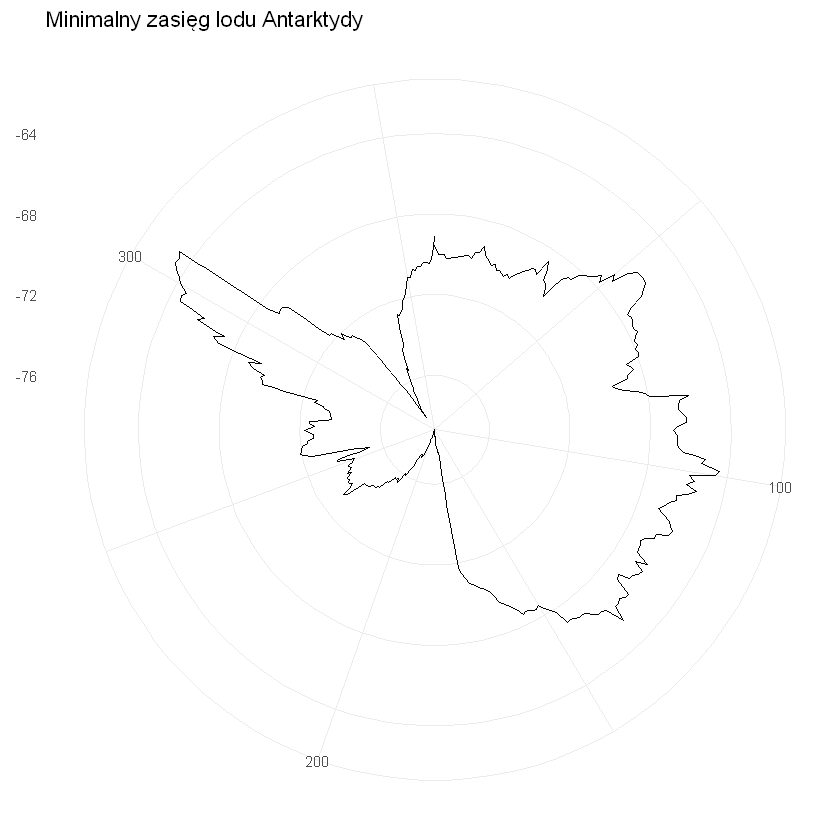

In [10]:
ice_edge_colnum <- length(colnames(daily_ice_edge))

ice_edge_min <- c()
open_water_min <- c()

for (i in 2:(ice_edge_colnum - 1)) {
  ice_edge_min[i - 1] <- (min(daily_ice_edge[, i]))
  open_water_min[i - 1] <- (min(daily_open_water[, i]))
}

ice_edge_min <- as.data.frame(ice_edge_min)

plot(
  x = seq_along(t(ice_edge_min)), y = t(ice_edge_min), type = "l",
  col = "blue", xlab = "Kąt w st.", ylab = "Zasięg pokrywy lodowej",
  main = "Minimalny zasięg lodu Antarktydy"
)

ggplot(
  data = ice_edge_min, aes(x = seq_along(ice_edge_min), y = ice_edge_min)
) +
  geom_line() +
  ggtitle("Minimalny zasięg lodu Antarktydy") +
  coord_polar() +
  theme_minimal() +
  theme(axis.title = element_blank())